In [26]:
# Import helper module from local folder
import sys
import os
sys.path.append(os.getcwd()) 
from resources import helper

# Numerical and plotting tools
import numpy as np
import matplotlib.pyplot as plt

# Import SI unit conversion factors
from resources.helper import GHz, MHz, kHz, us, ns

In [ ]:
# Importing standard Qiskit libraries
from qiskit import IBMQ
from qiskit.tools.jupyter import *

IBMQ.save_account('YOUR-IBM-TOKEN')

print(str(IBMQ.stored_account()))

# Loading your IBM Quantum account
IBMQ.load_account()
IBMQ.providers() # see a list of providers you have access to

In [28]:
from qiskit.pulse import DriveChannel, Gaussian

In [29]:
# Get the special provider assigned to you using information from the output above
hub_name = 'iqc2021-1' # e.g. 'iqc2021-1'
group_name = 'challenge-69' # e.g. 'challenge-1'
project_name = 'ex4' # Your project name should be 'ex4'
provider = IBMQ.get_provider(hub=hub_name, group=group_name, project=project_name)

# Get `ibmq_jakarta` backend from the provider
backend_name = 'ibmq_jakarta'
backend = provider.get_backend(backend_name)
backend # See details of the `ibmq_jakarta` quantum system

<IBMQBackend('ibmq_jakarta') from IBMQ(hub='iqc2021-1', group='challenge-69', project='ex4')>

In [38]:
from qiskit import pulse
from qiskit.pulse import Play, Schedule, DriveChannel

# Please use qubit 0 throughout the notebook
qubit = 0

In [39]:
backend_config = backend.configuration()
exc_chans = helper.get_exc_chans(globals())
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns") 

Sampling time: 0.2222222222222222 ns


In [40]:
backend_defaults = backend.defaults()
center_frequency = backend_defaults.qubit_freq_est
inst_sched_map = backend_defaults.instruction_schedule_map 
inst_sched_map.instructions

['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']

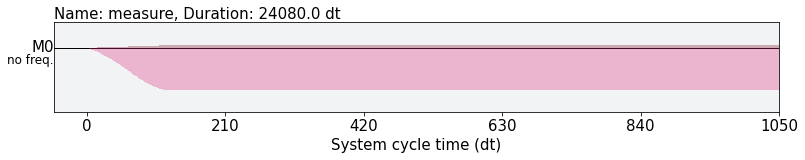

In [41]:
# Retrieve calibrated measurement pulse from backend
meas = inst_sched_map.get('measure', qubits=[qubit])
meas.exclude(channels=exc_chans).draw(time_range=[0,1000])

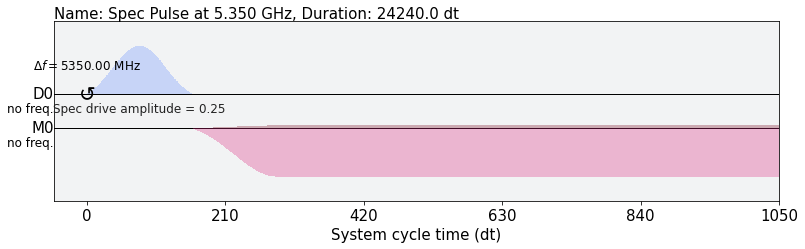

In [42]:
from qiskit.pulse import DriveChannel, Gaussian

# The same spec pulse for both 01 and 12 spec
drive_amp = 0.25
drive_duration = inst_sched_map.get('x', qubits=[qubit]).duration

# Calibrated backend pulse use advanced DRAG pulse to reduce leakage to the |2> state.
# Here we will use simple Gaussian pulse

drive_sigma = drive_duration // 4 # DRAG pulses typically 4*sigma long. 
spec_pulse = Gaussian(duration=drive_duration, amp=drive_amp, 
                        sigma=drive_sigma, name=f"Spec drive amplitude = {drive_amp}")

# Construct an np array of the frequencies for our experiment
spec_freqs_GHz = helper.get_spec01_freqs(center_frequency, qubit)

# Create the base schedule
# Start with drive pulse acting on the drive channel
spec01_scheds = []
for freq in spec_freqs_GHz:
    with pulse.build(name="Spec Pulse at %.3f GHz" % freq) as spec01_sched:
        with pulse.align_sequential():
            # Pay close attention to this part to solve the problem at the end
            pulse.set_frequency(freq*GHz, DriveChannel(qubit))
            pulse.play(spec_pulse, DriveChannel(qubit))
            pulse.call(meas)
            
    spec01_scheds.append(spec01_sched)

# Draw spec01 schedule
spec01_scheds[-1].exclude(channels=exc_chans).draw(time_range=[0,1000])

In [ ]:
from qiskit.tools.monitor import job_monitor

# Run the job on a real backend
spec01_job = backend.run(spec01_scheds, job_name="Spec 01", **helper.job_params) 

print(spec01_job.job_id())
job_monitor(spec01_job)

Spec01 frequency is 5.237424 GHz


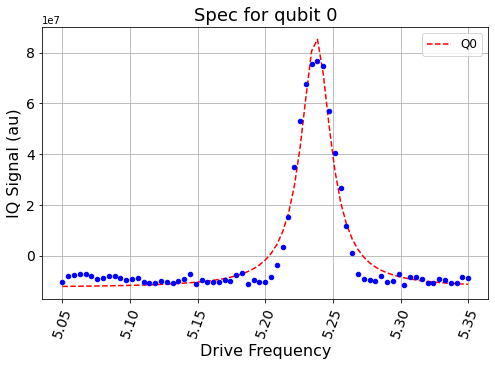

In [45]:
from resources.helper import SpecFitter

amp_guess = 5e6
f01_guess = 10
B = 1.2
C = -0.1
fit_guess = [amp_guess, f01_guess, B, C]

fit = SpecFitter(spec01_job.result(), spec_freqs_GHz, qubits=[qubit], fit_p0=fit_guess)
fit.plot(0, series='z')
f01 = fit.spec_freq(0, series='z')
print("Spec01 frequency is %.6f GHz" % f01)

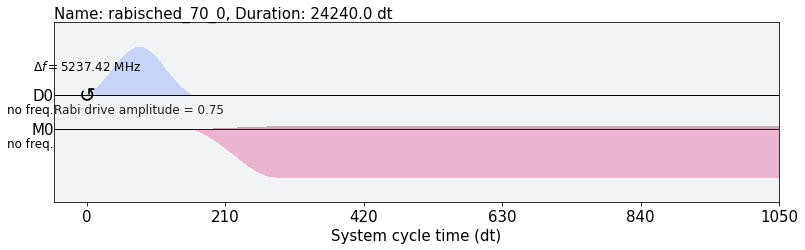

In [46]:
max_rabi_amp = 0.75
rabi_amps = helper.get_rabi_amps(max_rabi_amp)

rabi_scheds = []
for ridx, amp in enumerate(rabi_amps):
    with pulse.build(name="rabisched_%d_0" % ridx) as sched: # '0' corresponds to Rabi
        with pulse.align_sequential():
            pulse.set_frequency(f01*GHz, DriveChannel(qubit))
            rabi_pulse = Gaussian(duration=drive_duration, amp=amp, \
                              sigma=drive_sigma, name=f"Rabi drive amplitude = {amp}")
            pulse.play(rabi_pulse, DriveChannel(qubit))
            pulse.call(meas)
    rabi_scheds.append(sched)

# Draw rabi schedule
rabi_scheds[-1].exclude(channels=exc_chans).draw(time_range=[0,1000])

In [ ]:
# Run the job on a real device
rabi_job = backend.run(rabi_scheds, job_name="Rabi", **helper.job_params)

print(rabi_job.job_id())
job_monitor(rabi_job)

# If the queuing time is too long, you can save the job id 
# And retrieve the job after it's done
# Replace 'JOB_ID' with the the your job id and uncomment to line below
#rabi_job = backend.retrieve_job('JOB_ID')

Pi amplitude is 0.205


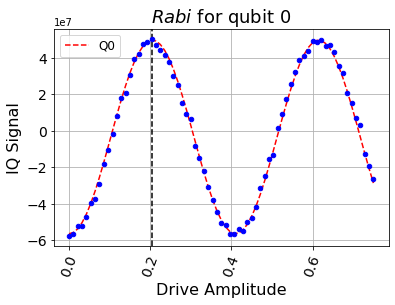

In [48]:
from qiskit.ignis.characterization.calibrations.fitters import RabiFitter

amp_guess = 5e7
fRabi_guess = 2
phi_guess = 0.5
c_guess = 0
fit_guess = [amp_guess, fRabi_guess, phi_guess, c_guess]

fit = RabiFitter(rabi_job.result(), rabi_amps, qubits=[qubit], fit_p0=fit_guess)
fit.plot(qind=0, series='0')
x180_amp = fit.pi_amplitude()
print("Pi amplitude is %.3f" % x180_amp)

<div id='problem'></div>
<div class="alert alert-block alert-success">

## Step 3 (Problem): Find $|1\rangle \rightarrow |2\rangle$ transition frequency
    
In order to observe the transition between the $|1\rangle$ and $|2\rangle$ states of the transmon, you need to: 

1. Apply an $X_\pi$ pulse to transition the qubit from $|0\rangle$ to $|1\rangle$.
1. Apply a second pulse with varying frequency to find the $|1\rangle \rightarrow |2\rangle$ transition.

</div>
<div class="alert alert-block alert-danger">
The cell below is the only one you need to modify in the entire notebook. 
</div>

In [49]:
backend_defaults = backend.defaults()
center_frequency = backend_defaults.qubit_freq_est
inst_sched_map = backend_defaults.instruction_schedule_map 
inst_sched_map.instructions

['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']

In [50]:
# Define pi pulse
drive_duration = inst_sched_map.get('x', qubits=[qubit]).duration

x_pulse = Gaussian(duration=drive_duration,
                     amp=x180_amp, 
                     sigma=drive_sigma,
                     name='x_pulse')

def build_spec12_pulse_schedule(freq, anharm_guess_GHz):  
    
    with pulse.build(name="Spec Pulse at %.3f GHz" % (freq+anharm_guess_GHz)) as spec12_schedule:
        with pulse.align_sequential():            
            # WRITE YOUR CODE BETWEEN THESE LINES - START

            pulse.set_frequency(f01*GHz, DriveChannel(qubit))
            pulse.play(x_pulse, DriveChannel(qubit))

            pulse.set_frequency((freq+anharm_guess_GHz)*GHz, DriveChannel(qubit))
            pulse.play(spec_pulse, DriveChannel(qubit))

            pulse.call(meas)

            # WRITE YOUR CODE BETWEEN THESE LINES - END
    return spec12_schedule

The anharmonicity of our transmon qubits is typically around $-300$ MHz, so we will sweep around that value. 

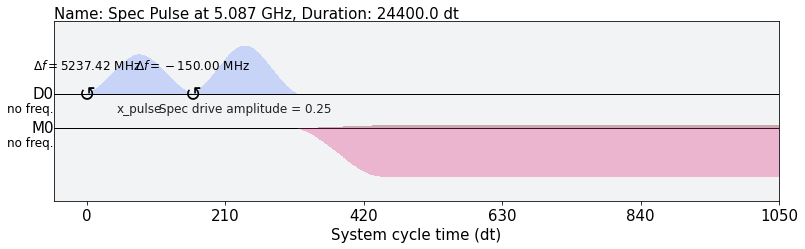

In [51]:
anharmonicity_guess_GHz = -0.3 # your anharmonicity guess
freqs_GHz = helper.get_spec12_freqs(f01, qubit)

# Now vary the sideband frequency for each spec pulse
spec12_scheds = []
for freq in freqs_GHz:
    spec12_scheds.append(build_spec12_pulse_schedule(freq, anharmonicity_guess_GHz))

# Draw spec12 schedule   
spec12_scheds[-1].exclude(channels=exc_chans).draw(time_range=[0,1000])

In [52]:
# Run the job on a real device
spec12_job = backend.run(spec12_scheds, job_name="Spec 12", **helper.job_params)

print(spec12_job.job_id())
job_monitor(spec12_job)

# If the queuing time is too long, you can save the job id 
# And retrieve the job after it's done
# Replace 'JOB_ID' with the the your job id and uncomment to line below
#spec12_job = backend.retrieve_job('JOB_ID')

/home/qiskit/.local/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


60af4b6a29aa60582e734112
Job Status: job has successfully run


### Fit the Spectroscopy Data

<div id='fit-f12'></div>

We will again fit the spectroscopy signal to a Lorentzian function of the form

$$ \frac{AB}{\pi[(f-f_{12})^2 + B^2]} + C $$

to find the frequency of the $|1\rangle \to |2\rangle$ transition $f_{12}$ with these fitting parameters:

Parameter | Corresponds to
 --- | ---
 $A$ | amplitude
 $f_{12}$ | 12 frequency guess (GHz)
 $B$ | scale
 $C$ | offset
 
 
<div class="alert alert-block alert-danger">

**Note:** You may need to modify the fitting parameters below to get a good fit.

</div>

Spec12 frequency is 4.897585 GHz


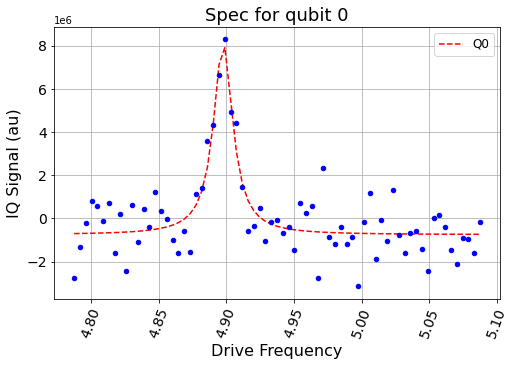

In [53]:
amp_guess = 5e7
f12_guess = f01 - 0.3
B = .1
C = 0
fit_guess = [amp_guess, f12_guess, B, C]

fit = SpecFitter(spec12_job.result(), freqs_GHz+anharmonicity_guess_GHz, qubits=[qubit], fit_p0=fit_guess)
fit.plot(0, series='z')
f12 = fit.spec_freq(0, series='z')
print("Spec12 frequency is %.6f GHz" % f12)

In [54]:
# Check your answer using following code
from qc_grader import grade_ex4
grade_ex4(f12,qubit,backend_name)

Grading your answer for ex4. Please wait...

Congratulations 🎉! Your answer is correct.
Feel free to submit your answer.



## Calculating $E_J/E_c$

Modifying the equations in the introduction section, we can calculate $E_c$ and $E_J$ using $f_{01}$ and $f_{12}$ obtained from the pulse experiments:

$$
E_c = -\delta = f_{01} - f_{12} \qquad E_J = \frac{(2f_{01}-f_{12})^2}{8(f_{01}-f_{12})}
$$

In [56]:
Ec = f01 - f12
Ej = (2*f01-f12)**2/(8*(f01-f12))
print(f"Ej/Ec: {Ej/Ec:.2f}") # This value is typically ~ 30 

Ej/Ec: 33.67
